<a href="https://colab.research.google.com/github/rahiakela/computer-vision-research-and-practice/blob/main/computer-vision-case-studies/object-detections/r-cnn-object-detection-series/2_selective_search_for_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OpenCV Selective Search for Object Detection

Automatic region proposal algorithms such as Selective Search paved the way for Girshick et al.’s seminal R-CNN paper, which gave rise to highly accurate deep learning-based object detectors.

Furthermore, research with Selective Search and object detection has allowed researchers to create state-of-the-art Region Proposal Network (RPN) components that are even more accurate and more efficient than Selective Search (see Girshick et al.’s follow-up 2015 paper on Faster R-CNNs).

But before we can get into RPNs, we first need to understand how Selective Search works, including how we can leverage Selective Search for object detection with OpenCV.

## Setup

In [10]:
# import the necessary packages
import numpy as np
import argparse
import imutils
import time
import random
import cv2
from google.colab.patches import cv2_imshow

In [5]:
%%shell

wget -q https://github.com/rahiakela/computer-vision-research-and-practice/raw/main/computer-vision-case-studies/object-detections/r-cnn-object-detection-series/images/hummingbird.jpg
wget -q https://github.com/rahiakela/computer-vision-research-and-practice/raw/main/computer-vision-case-studies/object-detections/r-cnn-object-detection-series/images/lawn_mower.jpg
wget -q https://github.com/rahiakela/computer-vision-research-and-practice/raw/main/computer-vision-case-studies/object-detections/r-cnn-object-detection-series/images/stingray.jpg

## Selective Search

We’ll discuss the concept of region proposals via Selective Search and how they can efficiently replace the traditional method of using image pyramids and sliding windows to detect objects in an image.

From there, we’ll review the Selective Search algorithm in detail, including how it over-segments an image via:

- Color similarity
- Texture similarity
- Size similarity
- Shape similarity
- A final meta-similarity, which is a linear combination of the above similarity measures

The general idea is that a region proposal algorithm should inspect the image and attempt to find regions of an image that likely contain an object (think of region proposal as a cousin to saliency detection).

The region proposal algorithm should:
1. Be faster and more efficient than sliding windows and image pyramids
2. Accurately detect the regions of an image that could contain an object
3. Pass these “candidate proposals” to a downstream classifier to actually label the regions, thus completing the object detection framework

Selective Search merges superpixels in a hierarchical fashion based on five key similarity measures:

- **Color similarity**: Computing a 25-bin histogram for each channel of an image, concatenating them together, and obtaining a final descriptor that is 25×3=75-d. Color similarity of any two regions is measured by the histogram intersection distance.
- **Texture similarity**: For texture, Selective Search extracts Gaussian derivatives at 8 orientations per channel (assuming a 3-channel image). These orientations are used to compute a 10-bin histogram per channel, generating a final texture descriptor that is 8x10x=240-d. To compute texture similarity between any two regions, histogram intersection is once again used.
- **Size similarity**: The size similarity metric that Selective Search uses prefers that smaller regions be grouped earlier rather than later. Anyone who has used Hierarchical Agglomerative Clustering (HAC) algorithms before knows that HACs are prone to clusters reaching a critical mass and then combining everything that they touch. By enforcing smaller regions to merge earlier, we can help prevent a large number of clusters from swallowing up all smaller regions.
- **Shape similarity/compatibility**: The idea behind shape similarity in Selective Search is that they should be compatible with each other. Two regions are considered “compatible” if they “fit” into each other (thereby filling gaps in our regional proposal generation). Furthermore, shapes that do not touch should not be merged.
- **A final meta-similarity measure**: A final meta-similarity acts as a linear combination of the color similarity, texture similarity, size similarity, and shape similarity/compatibility.

The results of Selective Search applying these hierarchical similarity measures can be seen in the following figure:

<img src='https://github.com/rahiakela/computer-vision-research-and-practice/blob/main/computer-vision-case-studies/object-detections/r-cnn-object-detection-series/images/opencv_selective_search_hierarchical.png?raw=1' width='800'/>

On the bottom layer of the pyramid, we can see the original over-segmentation/superpixel generation from the Felzenszwalb method.

In the middle layer, we can see regions being joined together, eventually forming the final set of proposals (top).

If you are using Selective Search, just keep in mind that the Selective Search algorithm will not give you class label predictions — it is assumed that your downstream classifier will do that for you.




## Implementing Selective Search with OpenCV

We are now ready to implement Selective Search with OpenCV!

In [18]:
def selective_search(image, methods="fast"):
  """
  image: The path to your input image.
  methods: The Selective Search algorithm to use. You have two choices — either "fast" or "quality".
  """

  # load the input image
  image = cv2.imread(image)

  # initialize OpenCV's selective search implementation and set the input image
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)

  # check to see if we are using the *fast* but *less accurate* version of selective search
  if methods == "fast":
    print("[INFO] using *fast* selective search")
    ss.switchToSelectiveSearchFast()
  else:  # otherwise we are using the *slower* but *more accurate* version
    print("[INFO] using *quality* selective search")
    ss.switchToSelectiveSearchQuality()
  
  # run selective search on the input image
  start = time.time()
  rects = ss.process()
  end = time.time()

  # show how along selective search took to run along with the total number of returned region proposals
  print("[INFO] selective search took {:.4f} seconds".format(end - start))
  print("[INFO] {} total region proposals".format(len(rects)))

  output = image.copy()

  # sloop over the region proposals in chunks (so we can better visualize them)
  for i in range(0, len(rects), 100):  
    # clone the original image so we can draw on it

    # loop over the current subset of region proposals  
    for (x, y, w, h) in rects[i: i + 100]:  
      # draw the region proposal bounding box on the image
      color = [random.randint(0, 255) for j in range(0, 3)]
      cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)

  # show the output image
  cv2_imshow(output)

## OpenCV Selective Search results

We are now ready to apply Selective Search with OpenCV to our own images.

[INFO] using *fast* selective search
[INFO] selective search took 3.0899 seconds
[INFO] 556 total region proposals


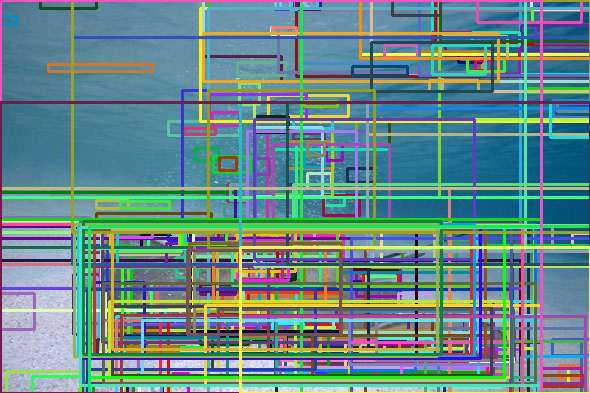

In [19]:
selective_search(image="stingray.jpg")

If you’re confused by this visualization, consider the end goal of Selective Search: to replace traditional computer vision object detection techniques such as sliding windows and image pyramids with a more efficient region proposal generation method.

Thus, Selective Search will not tell you what is in the ROI, but it tells you that the ROI is “interesting enough” to passed on to a downstream classifier (ex., SVM, CNN, etc.) for final classification.

Let’s apply Selective Search to the same image, but this time, use the --method quality mode:

[INFO] using *quality* selective search
[INFO] selective search took 12.5530 seconds
[INFO] 4230 total region proposals


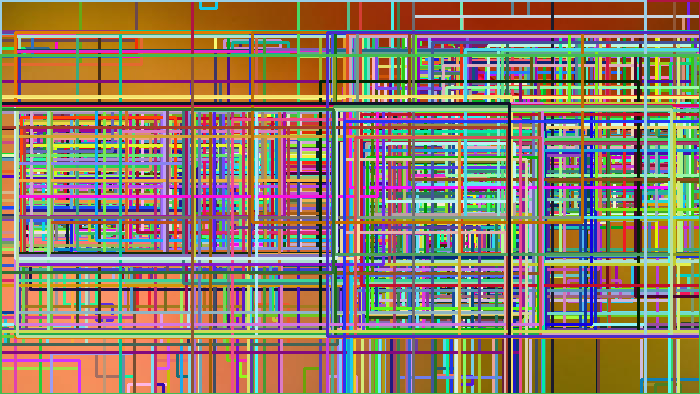

In [20]:
selective_search(image="hummingbird.jpg", methods="quality")

The “quality” Selective Search method generated 286% more region proposals but also took 247% longer to run.

Whether or not you should use the “fast” or “quality” mode is dependent on your application.


In most cases, the “fast” Selective Search is sufficient, but you may choose to use the “quality” mode:

- When performing inference and wanting to ensure you generate more quality regions to your downstream classifier (of course, this means that real-time detection is not a concern)
- When using Selective Search to generate training data, thereby ensuring you generate more positive and negative regions for your classifier to learn from

##Summary

Selective Search works by over-segmenting an image by combining regions based on five key components:

- Color similarity
- Texture similarity
- Size similarity
- Shape similarity
- A final meta-similarity, which is a linear combination of the above similarity measures

It’s important to note that Selective Search itself does not perform object detection.

Instead, Selective Search returns proposal regions that could contain an object.

The idea here is that we replace our computationally expensive, highly inefficient sliding windows and image pyramids with a less expensive, more efficient Selective Search.

Next, I’ll show you how to take the proposal regions generated by Selective Search and then run an image classifier on top of them, allowing you to create an ad hoc deep learning-based object detector!